# Beer Simulation Game
Simulate the beer simulation game in simpy. Assume each time step corre- sponds to one week. Consider the supply chain that is similar to what you played in in the game.

Retailer → Wholesaler → Distributor → Factory. Assume a lead time that has a uniform distribution between one and four weeks. (The lead time can be one, two , three or four weeks with equal probability). This lead time exists between all entities.

Assume the customer demand is 100k with probability 15%, 150k with probability 15% and 200k with probability 70 %. The cost of holding a case is 0.5\$ and cost of missing an order is 1\$. For each entity in the chain, assume the algorithm used to calculate the demand if is similar to the newsvendor problem.

Run the game for 50 time steps.

In [ ]:
import simpy
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math
from scipy.optimize import minimize_scalar

## Assumptions:

*   Chain: (Customer) -> Retailer -> Wholesaler -> Distributor -> Factory
*   Lead time distribution: U(1, 4)
*   Customer demand distribution:
    -   100k: 15%
    -   150k: 15%
    -   200k: 70%
*   Timesteps: 50
*   Costs:
    -   holding cost: 0.5
    -   missing cost: 1.0
*   Initial inventory: the mean of lead time * the mean of demand = 443,750





In [ ]:
### calculate the mean and standard deviation of demand
demand_mean = 100000 * 0.15 + 150000 * 0.15 + 200000 * 0.7
demand_std = round(math.sqrt((100000 - demand_mean) ** 2 * 0.15 + (150000 - demand_mean) ** 2 * 0.15 + (200000 - demand_mean) ** 2 * 0.7), 2)

### assume the initial inventory 
leadtime_mean = (1 + 2 + 3 + 4) / 4
initial_inventory = round(demand_mean * leadtime_mean)

print(f'The mean and standard deviation for the demand distribution are {demand_mean} and {demand_std} respectively.')
print(f'Assume the initial inventory is: {initial_inventory}.')

The mean and standard deviation for the demand distribution are 177500.0 and 36996.62 respectively.
Assume the initial inventory is: 443750.


In [ ]:
### customer
class Customer:
    def __init__(self, env):
        self.env = env
        self.demand = self.generate_demand()
        self.action = env.process(self.run())
    
    def generate_demand(self): ### set up demand distribution
        rand_num = random.uniform(0, 1)
        if rand_num < 0.15:
            return 100000
        elif rand_num <= 0.3:
            return 150000
        else:
            return 200000

    def run(self):
        while True:
            demand = self.generate_demand()
            yield self.env.timeout(1)

In [ ]:
### retailer
class Retailer:
    def __init__(self, env, customer, wholesaler):
        self.env = env
        self.customer = customer
        self.wholesaler = wholesaler
        self.demand = []
        self.initial_inventory = initial_inventory
        self.inventory = []
        self.backlog = []
        self.orders_placed = []
        self.order_arriving = []
        self.order_received_time = []
        self.order_sent = 0
        self.weekly_costs = []
        self.action = env.process(self.run())
    
    def generate_demand(self, demand): 
        self.demand.append(demand)

    def generate_leadtime(self): # set up lead time distribution
        self.order_received_time.append(random.randint(1, 4) + self.env.now)
        return random.randint(1, 4)

    def calculate_order_placed(self):
        # newsvendor model
        demand_dist = {}
        for d in self.demand:
            if d in demand_dist:
                demand_dist[d] += 1
            else:
                demand_dist[d] = 1

        total_demand = len(self.demand)
        relative_prob = {d: p / total_demand for d, p in demand_dist.items()} # calculate the probability of each demand

        def cost_function(x): # define the cost function for linear programming
            total_cost = 0
            holding_cost = 0.5 # undearage cost
            missing_cost = 1 # overage cost
            for d, p in relative_prob.items():
                if d - x > 0:
                    cost = (d - x) * missing_cost * p
                    total_cost = total_cost + cost
                else:
                    cost = (x - d) * holding_cost * p
                    total_cost = total_cost + cost
            return total_cost

        optimal_quan = minimize_scalar(cost_function, bounds = [0, np.max(list(relative_prob.keys()))], method = 'bounded') # use linear programming to find out the optimal holding inventory

        if len(self.backlog) > 1: # consider the backlog
            if self.backlog[-1] > 0:
              self.orders_placed.append(round(optimal_quan.x + self.backlog[-1]))
            else:
                if optimal_quan.x - self.inventory[-1] > 0:
                    self.orders_placed.append(round(optimal_quan.x - self.inventory[-1]))
                else:
                    self.orders_placed.append(0)
        else:
            self.orders_placed.append(0)

    def calculate_order_received(self):
        order_log = {k: v for k, v in zip(self.order_arriving, self.order_received_time)}
        order_received = 0
        for k, v in order_log.items():
            if v == self.env.now + 1:
                order_received = order_received + k # cummulate the orders arrived in the current week
        return order_received
    
    def order_arriving_log(self): # record arriving orders from wholesaler
        self.order_arriving.append(self.wholesaler.order_sent) # receive order sent from wholesaler

    def calculate_order_sent(self, order_received, demand):
        if self.demand:
            if len(self.inventory) < 1:
                order_sent = demand
            else:
                if (self.inventory[-1] + order_received - demand) >= 0:
                    order_sent = demand
                elif (self.inventory[-1] + order_received) >= 0:
                    order_sent = self.inventory[-1] + order_received
                else:
                    order_sent = 0
        else:
            order_sent = 0

        return order_sent

    def calculate_inventory(self, order_received, order_sent):
        if len(self.inventory) < 1:
            self.inventory.append(self.initial_inventory + order_received - order_sent)
        elif self.backlog[-1] > 0:
            self.inventory.append(0)
        else:
            self.inventory.append(self.inventory[-1] + order_received - order_sent)

    def calculate_backlog(self, order_received, demand):
        if len(self.backlog) < 1:
            self.backlog.append(0)
        else:
            if demand:
                if (self.inventory[-1] + order_received - demand - self.backlog[-1]) >= 0:
                    self.backlog.append(0)
                else:
                    backlog = max(0, self.backlog[-1] + (demand - order_received - self.inventory[-1]))
                    self.backlog.append(backlog)
            else:
                self.backlog.append(0)

    def calculate_cost(self):
        holding_cost = 0.5
        missing_cost = 1
        if self.env.now == 1:
            weekly_cost = self.inventory[-1] * holding_cost
        else:
            weekly_cost = self.inventory[-1] * holding_cost + self.backlog[-1] * missing_cost
        self.weekly_costs.append(round(weekly_cost))

    def run(self):
        while True:
            demand = self.customer.generate_demand() ### get the demand from customer
            self.generate_demand(demand)
            self.calculate_order_placed()
            
            self.order_arriving_log()
            self.generate_leadtime()
            order_received = self.calculate_order_received()
            order_sent = self.calculate_order_sent(order_received, demand)
            self.calculate_backlog(order_received, demand)
            self.calculate_inventory(order_received, order_sent)
            self.calculate_cost()
            yield self.env.timeout(1)

In [ ]:
### wholesaler
class Wholesaler:
    def __init__(self, env, retailer, distributor):
        self.env = env
        self.retailer = retailer
        self.distributor = distributor
        self.demand = []
        self.initial_inventory = initial_inventory
        self.inventory = []
        self.backlog = []
        self.orders_placed = []
        self.order_arriving = []
        self.order_received_time = []
        self.order_sent = 0
        self.weekly_costs = []
        self.action = env.process(self.run())
    
    def generate_demand(self, demand):
        self.demand.append(demand)

    def generate_leadtime(self):
        self.order_received_time.append(random.randint(1, 4) + self.env.now)
        return random.randint(1, 4)

    def calculate_order_placed(self):
        demand_dist = {}
        for d in self.demand:
            if d in demand_dist:
                demand_dist[d] += 1
            else:
                demand_dist[d] = 1

        total_demand = len(self.demand)
        relative_prob = {d: p / total_demand for d, p in demand_dist.items()}

        def cost_function(x):
            total_cost = 0
            holding_cost = 0.5
            missing_cost = 1
            for d, p in relative_prob.items():
                if d - x > 0:
                    cost = (d - x) * missing_cost * p
                    total_cost = total_cost + cost
                else:
                    cost = (x - d) * holding_cost * p
                    total_cost = total_cost + cost
            return total_cost

        optimal_quan = minimize_scalar(cost_function, bounds = [0, np.max(list(relative_prob.keys()))], method = 'bounded')

        if len(self.backlog) > 1: # consider the backlog
            if self.backlog[-1] > 0:
                self.orders_placed.append(round(optimal_quan.x + self.backlog[-1]))
            else:
                if optimal_quan.x - self.inventory[-1] > 0:
                    self.orders_placed.append(round(optimal_quan.x - self.inventory[-1]))
                else:
                    self.orders_placed.append(0)
        else:
            self.orders_placed.append(0)

    def calculate_order_received(self):
        order_log = {k: v for k, v in zip(self.order_arriving, self.order_received_time)}
        order_received = 0
        for k, v in order_log.items():
            if v == self.env.now + 1:
                order_received = order_received + k ### cummulate the orders arrived in the current week
        return order_received

    def order_arriving_log(self):
        self.order_arriving.append(self.distributor.order_sent) ### receive order sent from distributor

    def calculate_order_sent(self, order_received, demand):
        if self.demand:
            if len(self.inventory) < 1:
                order_sent = demand
            else:
                if (self.inventory[-1] + order_received - demand) >= 0:
                    order_sent = demand
                elif (self.inventory[-1] + order_received) >= 0:
                    order_sent = self.inventory[-1] + order_received
                else:
                    order_sent = 0
        else:
            order_sent = 0

        return order_sent

    def calculate_inventory(self, order_received, order_sent):
        if len(self.inventory) < 1:
            self.inventory.append(self.initial_inventory + order_received - order_sent)
        else:
            self.inventory.append(self.inventory[-1] + order_received - order_sent)

    def calculate_backlog(self, order_received, demand):
        if len(self.backlog) < 1:
            self.backlog.append(0)
        else:
            if demand:
                if (self.inventory[-1] + order_received - demand - self.backlog[-1]) >= 0:
                    self.backlog.append(0)
                else:
                    backlog = max(0, self.backlog[-1] + (demand - order_received - self.inventory[-1]))
                    self.backlog.append(backlog)
            else:
                self.backlog.append(0)

    def calculate_cost(self):
        holding_cost = 0.5
        missing_cost = 1
        if self.env.now == 1:
            weekly_cost = self.inventory[-1] * holding_cost
        else:
            weekly_cost = self.inventory[-1] * holding_cost + self.backlog[-1] * missing_cost
        self.weekly_costs.append(round(weekly_cost))

    def run(self):
        while True:
            demand = self.retailer.orders_placed[-1] ### get the demand from retailer
            self.generate_demand(demand)
            self.calculate_order_placed()
            
            self.order_arriving_log()
            self.generate_leadtime()
            order_received = self.calculate_order_received()
            self.order_sent = self.calculate_order_sent(order_received, demand)
            self.calculate_backlog(order_received, demand)
            self.calculate_inventory(order_received, self.order_sent)
            self.calculate_cost()
            yield self.env.timeout(1)

In [ ]:
### distributor
class Distributor:
    def __init__(self, env, wholesaler, factory):
        self.env = env
        self.wholesaler = wholesaler
        self.factory = factory
        self.demand = []
        self.initial_inventory = initial_inventory
        self.inventory = []
        self.backlog = []
        self.orders_placed = []
        self.order_arriving = []
        self.order_received_time = []
        self.order_sent = 0
        self.weekly_costs = []
        self.action = env.process(self.run())
    
    def generate_demand(self, demand):
        self.demand.append(demand)

    def generate_leadtime(self):
        self.order_received_time.append(random.randint(1, 4) + self.env.now)
        return random.randint(1, 4)

    def calculate_order_placed(self):
        demand_dist = {}
        for d in self.demand:
            if d in demand_dist:
                demand_dist[d] += 1
            else:
                demand_dist[d] = 1

        total_demand = len(self.demand)
        relative_prob = {d: p / total_demand for d, p in demand_dist.items()}

        def cost_function(x):
            total_cost = 0
            holding_cost = 0.5
            missing_cost = 1
            for d, p in relative_prob.items():
                if d - x > 0:
                    cost = (d - x) * missing_cost * p
                    total_cost = total_cost + cost
                else:
                    cost = (x - d) * holding_cost * p
                    total_cost = total_cost + cost
            return total_cost

        optimal_quan = minimize_scalar(cost_function, bounds = [0, np.max(list(relative_prob.keys()))], method = 'bounded')

        if len(self.backlog) > 1: # consider the backlog
            if self.backlog[-1] > 0:
                self.orders_placed.append(round(optimal_quan.x + self.backlog[-1]))
            else:
                if optimal_quan.x - self.inventory[-1] > 0:
                    self.orders_placed.append(round(optimal_quan.x - self.inventory[-1]))
                else:
                    self.orders_placed.append(0)
        else:
            self.orders_placed.append(0)

    def calculate_order_received(self):
        order_log = {k: v for k, v in zip(self.order_arriving, self.order_received_time)}
        order_received = 0
        for k, v in order_log.items():
            if v == self.env.now + 1:
                order_received = order_received + k ### cummulate the orders arrived in the current week
        return order_received

    def order_arriving_log(self):
        self.order_arriving.append(self.factory.order_sent) ### receive order sent from factory

    def calculate_order_sent(self, order_received, demand):
        if self.demand:
            if len(self.inventory) < 1:
                order_sent = demand
            else:
                if (self.inventory[-1] + order_received - demand) >= 0:
                    order_sent = demand
                elif (self.inventory[-1] + order_received) >= 0:
                    order_sent = self.inventory[-1] + order_received
                else:
                    order_sent = 0
        else:
            order_sent = 0

        return order_sent

    def calculate_inventory(self, order_received, order_sent):
        if len(self.inventory) < 1:
            self.inventory.append(self.initial_inventory + order_received - order_sent)
        else:
            self.inventory.append(self.inventory[-1] + order_received - order_sent)

    def calculate_backlog(self, order_received, demand):
        if len(self.backlog) < 1:
            self.backlog.append(0)
        else:
            if demand:
                if (self.inventory[-1] + order_received - demand - self.backlog[-1]) >= 0:
                    self.backlog.append(0)
                else:
                    backlog = max(0, self.backlog[-1] + (demand - order_received - self.inventory[-1]))
                    self.backlog.append(backlog)
            else:
                self.backlog.append(0)

    def calculate_cost(self):
        holding_cost = 0.5
        missing_cost = 1
        if self.env.now == 1:
            weekly_cost = self.inventory[-1] * holding_cost
        else:
            weekly_cost = self.inventory[-1] * holding_cost + self.backlog[-1] * missing_cost
        self.weekly_costs.append(round(weekly_cost))

    def run(self):
        while True:
            demand = self.wholesaler.orders_placed[-1] ### the demand comes from the order placed by wholesaler
            self.generate_demand(demand)
            self.calculate_order_placed()

            self.order_arriving_log()
            self.generate_leadtime()
            order_received = self.calculate_order_received()
            self.order_sent = self.calculate_order_sent(order_received, demand)
            self.calculate_backlog(order_received, demand)
            self.calculate_inventory(order_received, self.order_sent)
            self.calculate_cost()
            yield self.env.timeout(1)

In [ ]:
### factory
class Factory:
    def __init__(self, env, distributor):
        self.env = env
        self.distributor = distributor
        self.demand = []
        self.initial_inventory = initial_inventory
        self.inventory = []
        self.backlog = []
        self.orders_produced = []
        self.order_sent = 0
        self.weekly_costs = []
        self.action = env.process(self.run())
    
    def generate_demand(self, demand):
        self.demand.append(demand)

    def calculate_order_produced(self):
        demand_dist = {}
        for d in self.demand:
            if d in demand_dist:
                demand_dist[d] += 1
            else:
                demand_dist[d] = 1

        total_demand = len(self.demand)
        relative_prob = {d: p / total_demand for d, p in demand_dist.items()}

        def cost_function(x):
            total_cost = 0
            holding_cost = 0.5
            missing_cost = 1
            for d, p in relative_prob.items():
                if d - x > 0:
                    cost = (d - x) * missing_cost * p
                    total_cost = total_cost + cost
                else:
                    cost = (x - d) * holding_cost * p
                    total_cost = total_cost + cost
            return total_cost

        optimal_quan = minimize_scalar(cost_function, bounds = [0, np.max(list(relative_prob.keys()))], method = 'bounded')

        if len(self.backlog) > 1:
            if self.backlog[-1] > 0:
                  self.orders_produced.append(round(optimal_quan.x + self.backlog[-1]))
            else:
                if optimal_quan.x - self.inventory[-1] > 0:
                    self.orders_produced.append(round(optimal_quan.x - self.inventory[-1]))
                else:
                    self.orders_produced.append(0)
        else:
            self.orders_produced.append(0)

    def calculate_order_sent(self, demand):
        if self.demand:
            if len(self.inventory) < 1:
                order_sent = demand
            else:
                if (self.inventory[-1] + self.orders_produced[-1] - demand) >= 0:
                    order_sent = demand
                elif (self.inventory[-1] + self.orders_produced[-1]) >= 0:
                    order_sent = self.inventory[-1] + self.orders_produced[-1]
                else:
                    order_sent = 0
        else:
            order_sent = 0

        return order_sent

    def calculate_inventory(self, order_sent):
        if len(self.inventory) < 1:
            self.inventory.append(self.initial_inventory + self.orders_produced[-1] - order_sent)
        else:
            self.inventory.append(self.inventory[-1] + self.orders_produced[-1] - order_sent)

    def calculate_backlog(self, demand):
        if len(self.backlog) < 1:
            self.backlog.append(0)
        else:
            if demand:
                if (self.inventory[-1] + self.orders_produced[-1] - demand - self.backlog[-1]) >= 0:
                    self.backlog.append(0)
                else:
                    backlog = max(0, self.backlog[-1] + (demand - self.orders_produced[-1] - self.inventory[-1]))
                    self.backlog.append(backlog)
            else:
                self.backlog.append(0)

    def calculate_cost(self):
        holding_cost = 0.5
        missing_cost = 1
        if self.env.now == 1:
            weekly_cost = self.inventory[-1] * holding_cost
        else:
            weekly_cost = self.inventory[-1] * holding_cost + self.backlog[-1] * missing_cost
        self.weekly_costs.append(round(weekly_cost))

    def run(self):
        while True:
            demand = self.distributor.orders_placed[-1] ### the demand comes from the order placed by distributor
            self.generate_demand(demand)
            self.calculate_order_produced()

            self.order_sent = self.calculate_order_sent(demand)
            self.calculate_backlog(demand)
            self.calculate_inventory(self.order_sent)
            self.calculate_cost()
            yield self.env.timeout(1)


In [ ]:
### run the environment
random.seed(0)
env = simpy.Environment()
customer = Customer(env)
retailer = Retailer(env, customer, None)
wholesaler = Wholesaler(env, retailer, None)
distributor = Distributor(env, wholesaler, None)
factory = Factory(env, distributor)

retailer.customer = customer
retailer.wholesaler = wholesaler
wholesaler.retailer = retailer
wholesaler.distributor = distributor
distributor.wholesaler = wholesaler
distributor.factory = factory
factory.distributor = distributor

env.run(until = 50)

> 1. Plot the weekly costs of each entity as a function of time.

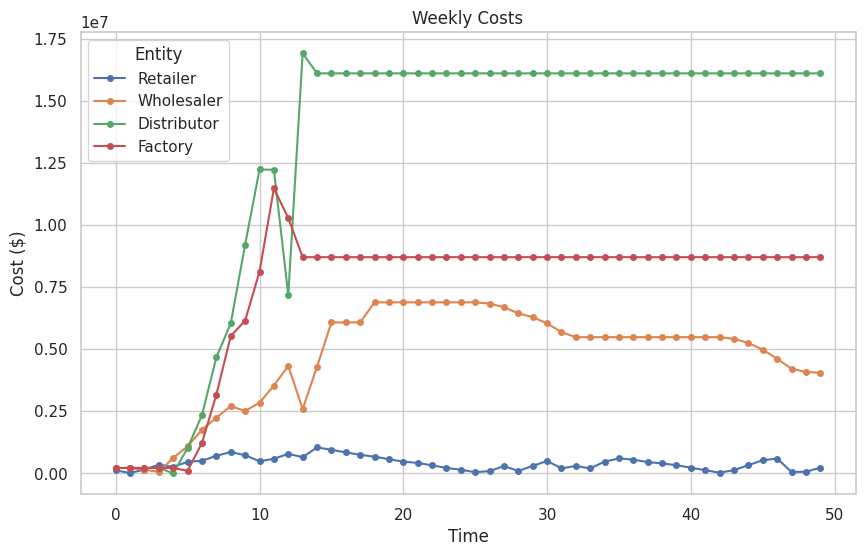

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize = (10, 6))
plt.plot(retailer.weekly_costs, label = 'Retailer', marker = 'o', markersize = 4)
plt.plot(wholesaler.weekly_costs, label = 'Wholesaler', marker = 'o', markersize = 4)
plt.plot(distributor.weekly_costs, label = 'Distributor', marker = 'o', markersize = 4)
plt.plot(factory.weekly_costs, label = 'Factory', marker = 'o', markersize = 4)
plt.xlabel('Time')
plt.ylabel('Cost ($)')
plt.title('Weekly Costs')
plt.legend(title = 'Entity')
plt.show()

> 2. Plot the inventory as a function of time.

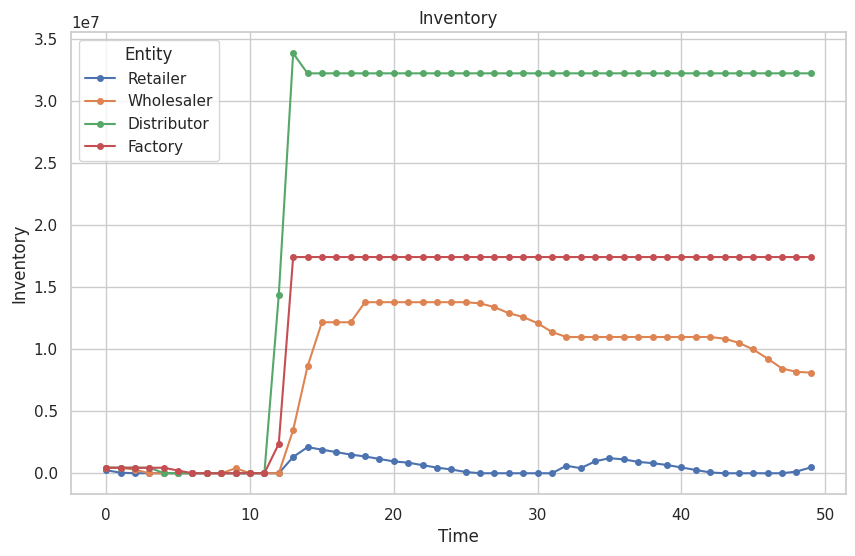

In [ ]:
plt.figure(figsize = (10, 6))
plt.plot(retailer.inventory, label = 'Retailer', marker = 'o', markersize = 4)
plt.plot(wholesaler.inventory, label = 'Wholesaler', marker = 'o', markersize = 4)
plt.plot(distributor.inventory, label = 'Distributor', marker = 'o', markersize = 4)
plt.plot(factory.inventory, label = 'Factory', marker = 'o', markersize = 4)
plt.xlabel('Time')
plt.ylabel('Inventory')
plt.title('Inventory')
plt.legend(title = 'Entity')
plt.show()

> 3. Plot the orders placed by each entity a function of time.

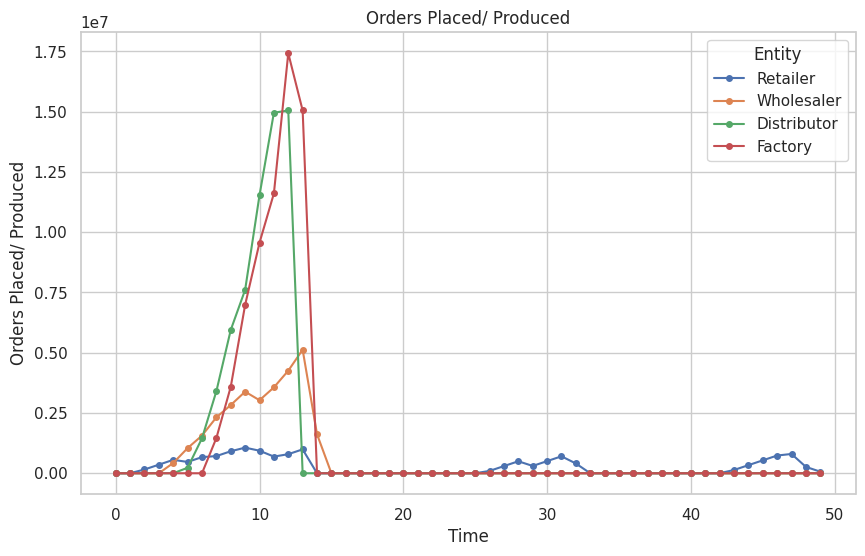

In [ ]:
plt.figure(figsize = (10, 6))
plt.plot(retailer.orders_placed, label = 'Retailer', marker = 'o', markersize = 4)
plt.plot(wholesaler.orders_placed, label = 'Wholesaler', marker = 'o', markersize = 4)
plt.plot(distributor.orders_placed, label = 'Distributor', marker = 'o', markersize = 4)
plt.plot(factory.orders_produced, label = 'Factory', marker = 'o', markersize = 4)
plt.xlabel('Time')
plt.ylabel('Orders Placed/ Produced')
plt.title('Orders Placed/ Produced')
plt.legend(title = 'Entity')
plt.show()